In [1]:
# Import all required packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime, time, timedelta
import calendar
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import sys
sys.path.insert(0, "/home/raj/ocf/pv-solar-farm-forecasting/ukpn/load/gsp/")

from gsp_power_data_utils import *

%matplotlib inline

## UKPN Dashboard Data Report

[UKPN dashbaord](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH) is provided by the organisation called "[UK Power Netowrks](https://www.ukpowernetworks.co.uk/)" through an open source analytics and monitroing interface called [Grafana](https://grafana.com/). It provides various metrics from the GSP such as Active Power Flow, Reactive Power Flow, Voltage , Frequency and Generator Outputs for all metered generation. For this data report, solar data generated from metered outputs has been considered. The data that can be manually downladable is in either csv or JSON format.

In [2]:
# Plotting a bar graph
folder_destination = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data"
count_dict = get_gsp_data_in_dict(
    folder_destination = folder_destination,
    count_gsp_data = True)
# Printing the total number of GSP's
print(f"The total number of Solar data points in each GSP locaion is as follows")
pprint.pprint(count_dict)
print("\n") 

The total number of Solar data points in each GSP locaion is as follows
{'braintree': 160819,
 'burwell': 161114,
 'canterbury_north': 161763,
 'ninefield': 161942,
 'northfleet_east': 160720,
 'norwich': 161272,
 'rayleigh': 155842,
 'richborough': 54767,
 'sellindge': 161864}


All the GSP Power data has been downloaded manually from the [dashboard](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH), but it will be automated as we move forward. The frequency of the data is 10Min, GSP's has different starting dates in their historic data, but it is live data, meaning the data downloaded will be upto the last 10th minute in the current hour of the current day.

In [60]:
# Getting the starting dates of each GSP data
data_dict = get_gsp_data_in_dict(folder_destination = folder_destination)
starting_dates = {}
ending_date = []
minutes_each_gsp = []
for gsp_name, data_frame in  data_dict.items():
    # Getting the starting dates adn ending date
    starting_dates[gsp_name] = data_frame.first_valid_index().strftime("%Y-%m-%d")
    ending_date.append(data_frame.last_valid_index().strftime("%Y-%m-%d"))
    # Getting the minutes
    data_frame["minutes"] = pd.to_datetime(data_frame.index).minute
    minutes = data_frame["minutes"].unique().tolist()
    minutes_each_gsp.append(minutes)

print("\nMost of the data has similar starting dates, and below are the common starting dates")
print(set(list(starting_dates.values())))
print("And the last or latest date for the current dataset is")
print(set(list(ending_date)))

print("\nThe interval frequency of all the GSP solar data in each hour is as follows")
pprint.pprint(np.unique(minutes_each_gsp).tolist())
print("\n")


Most of the data has similar starting dates, and below are the common starting dates
{'2021-12-30', '2019-12-16', '2019-12-23'}
{'2023-01-16'}

The interval frequency of all the GSP solar data in each hour is as follows
[0, 10, 20, 30, 40, 50]


From above it is observed that, the data for each GSP spans from '2021-12-xx' to '2023-01-16', and the it is of 10 minute intervaled data.

The data contains float values for each time stamp, and it is observed that there are negative values present in between after a rough look through the raw data. There are no NaN's present in the raw data, but there are 
1. missing time intervals
2. negative values
3. Duplicate Datetime timestamps

There are no NaN's present in the raw data, but the negative values are quite spreadout and there is no proper trend observed of negative values in the raw data. The percentage of negative values for each month in each GSP has been plotted below.

The check for NaN values has been performed!
No NaN Values are found in any GSP raw data

Checking for negative data:
Below are the GSP names with percentage of total negative values in their data


Text(0, 0.5, 'Percentage of negative values')

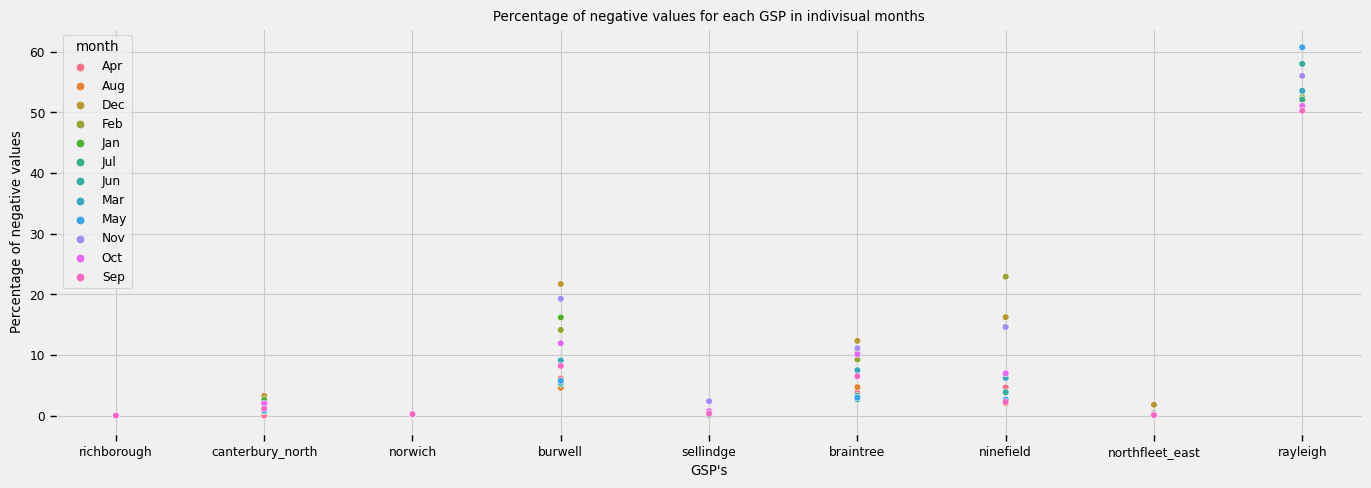

In [74]:
# Checks in pre-processing
check_nan = []
count_df = pd.DataFrame()

for gsp_name, data_frame in data_dict.items():

    # Checking for duplicate time stamps
    # TODO
    
    # Checking NaN's
    check_nan = data_frame.isnull().any().any()

    # Checking negative data
    negative_data_check = np.sum((data_frame[data_frame.columns[0]] < 0).values.ravel())
    # Getting months
    data_frame["month"] = pd.to_datetime(data_frame.index).month.values
    data_frame["month"] = data_frame["month"].apply(lambda x: calendar.month_abbr[x])
    # Group by months
    groupby_month = data_frame.groupby('month')[gsp_name]
    counts = groupby_month.agg(
        pos_count=lambda s: s.gt(0).sum(),
        neg_count=lambda s: s.lt(0).sum(),
        net_count=lambda s: s.gt(0).sum()- s.lt(0).sum()).astype(int)
    
    counts["perc_count"] = (counts["neg_count"]/(counts["pos_count"] + counts["neg_count"])) * 100

    counts["gsp_name"] = gsp_name
    counts = counts.reset_index(level=0)
    count_df = pd.concat([count_df, counts], ignore_index = True)

# Check for NaN's
print("The check for NaN values has been performed!")
if check_nan == True:
    print("There are NaN values")
else:
    print("No NaN Values are found in any GSP raw data")

# Check for negative data
print("\nChecking for negative data:")
print("Below are the GSP names with percentage of total negative values in their data")
sns.set_context('paper')
sns.scatterplot(
    data = count_df, 
    x = "gsp_name", 
    y = "perc_count", 
    hue = "month")
plt.title("Percentage of negative values for each GSP in indivisual months")
plt.xlabel("GSP's")
plt.ylabel("Percentage of negative values")


Looking at thr raw data, there has been a trend observed in the generated metered power values in a day. The power values which are in MW for each GSP, starts to rise linearly from the midnight, and starts spiking during a certain time of the day. It is fair assumption to think those spikes starts at the Sunrise time of the GSP location. After plotting the data against the __Sunset__ and __Sunrise__ times (Source - [link](https://www.timeanddate.com/astronomy/uk/canterbury)) of the __Canterbury__ GSP, the observation seems to be true.

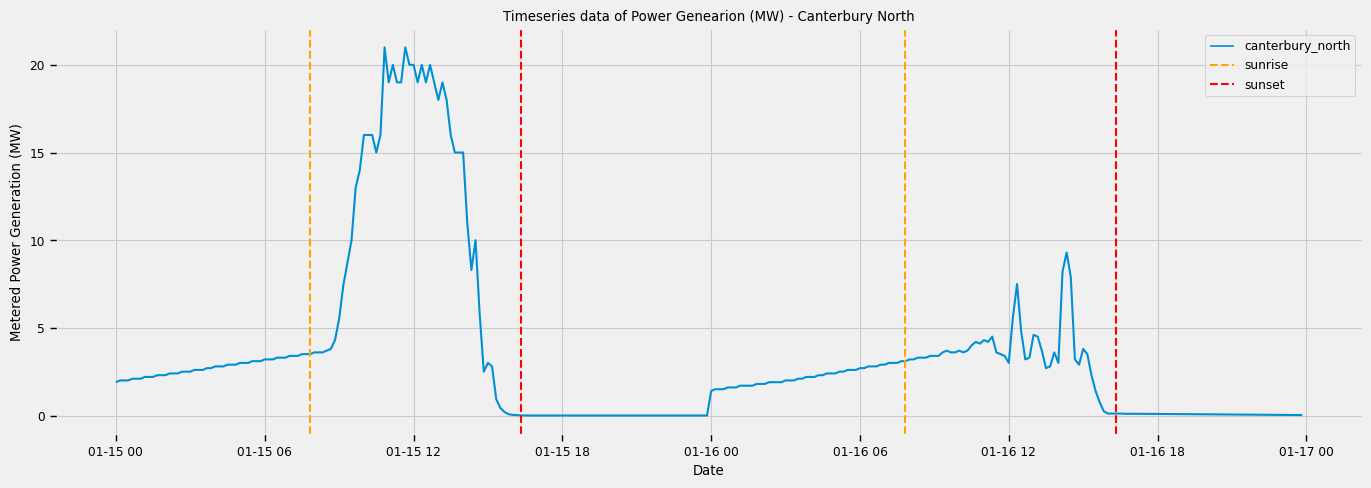

In [61]:
# Plotting Canterbury Metered power generation for the current month (18/01/2023)

# Loading the file
path_to_file = Path("/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

# Getting the 2023 Jan data
canterbury_df_jan = canterbury_df[canterbury_df.index.year == 2023]
canterbury_df_jan = canterbury_df_jan[np.in1d(canterbury_df_jan.index.day.values, [15,16,17])]

# Sunrise and Sunset time
sunrise_time = time(7, 50)
sunrise_time = canterbury_df_jan[np.in1d(canterbury_df_jan.index.time, sunrise_time)].index.values
sunset_time = time(16,20)
sunset_time = canterbury_df_jan[np.in1d(canterbury_df_jan.index.time, sunset_time)].index.values

def legend_without_duplicate_labels(figure):
    """Prevents legend labels from duplicating
    link - https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper right')

# Plotting
sns.lineplot(data = canterbury_df_jan, linewidth = 1.5)
for i in range(len(sunrise_time)):
    plt.axvline(sunrise_time[i], linewidth = 1.5, color = 'orange', linestyle = '--', label = 'sunrise')
    plt.axvline(sunset_time[i], linewidth = 1.5, color = 'red', linestyle = '--', label = 'sunset')
    # Naming legend
    legend_without_duplicate_labels(plt)
    plt.title("Timeseries data of Power Genearion (MW) - Canterbury North")
    plt.xlabel("Date")
    plt.ylabel("Metered Power Generation (MW)")
print("\n")

<function matplotlib.pyplot.show(close=None, block=None)>

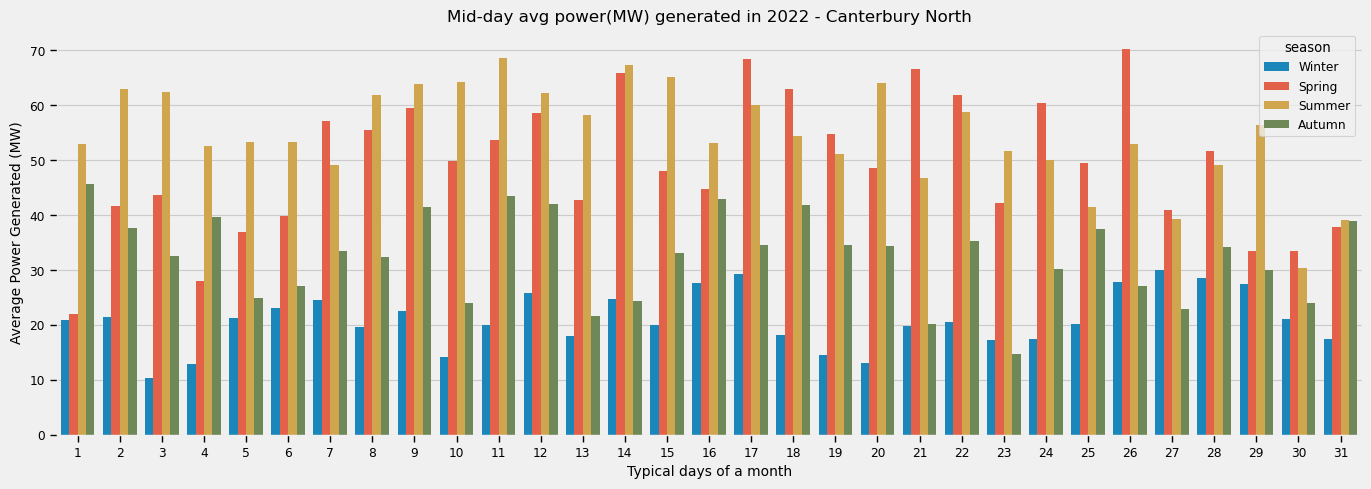

In [64]:
# Classification of power generated by seasons

# Loading the file
path_to_file = Path(r"/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

# Resetting the index
canterbury_df.reset_index(inplace=True)

# Defining Seasons
seasons = {
    1 : "Winter",
    2 : "Winter",
    3 : "Spring",
    4 : "Spring",
    5 : "Spring",
    6 : "Summer",
    7 : "Summer",
    8 : "Summer",
    9 : "Autumn",
    10 : "Autumn",
    11 : "Autumn",
    12 : "Winter"
}
# Getting the data for only 2022
canterbury_df_2022 = canterbury_df[canterbury_df["time_utc"].dt.year == 2022].reset_index(drop=True)

# Getting the data for the mid-day 11am to 1pm
canterbury_df_2022 = canterbury_df_2022.set_index("time_utc")
canterbury_df_2022  = canterbury_df_2022.between_time('11:00', '13:00')

# Getting the average for a single day
canterbury_avg_2022 = canterbury_df_2022.groupby([
    canterbury_df_2022.index.month, canterbury_df_2022.index.day])["canterbury_north"].mean().to_frame()

# Getting the seasons of the year
canterbury_avg_2022.index.set_names(['month' , 'date'], inplace = True)
canterbury_avg_2022.reset_index(inplace = True)
canterbury_avg_2022["season"] = canterbury_avg_2022["month"].apply(lambda month_number: seasons[month_number])
canterbury_avg_2022["month"] = canterbury_avg_2022["month"].apply(lambda month_number: calendar.month_abbr[month_number])

# Plot the data
# This plot classifies the average power generated on every mid-day (11am - 1pm) of a season day
# For example, the first bar represents the average of 1st day of every month in a season
ax = sns.barplot(data = canterbury_avg_2022, x = 'date', y = 'canterbury_north', hue = "season", ci = None)
ax.set_xlabel('Typical days of a month', fontsize = 10)
ax.set_ylabel('Average Power Generated (MW)', fontsize = 10)
ax.axes.set_title("Mid-day avg power(MW) generated in 2022 - Canterbury North", fontsize = 12)
plt.show


In [ ]:
# Interpolating the negative values in the data frame

# Loading the file
path_to_file = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv"
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)


# Getting the indices of the negative values
canterbury_negative_indices = check_for_negative_data(original_df = canterbury_df)
unique_dates_with_negative = canterbury_negative_indices.map(lambda t: t.date()).unique()

# Converting the dates to list
select_dates = random.sample(unique_dates_with_negative.to_list(), 1)

# Getting the required dataframe
final_dataframe = pd.DataFrame([])

for i in range(len(select_dates)):
    # Filtering dataframe based on each date with negative values
    originL_df = canterbury_df.loc[pd.to_datetime(canterbury_df.index.values).date == select_dates[i]]
    filter_df = check_for_negative_data(original_df = originL_df, replace_with_nan = True)

    # Interpolating the missing values
    start_date = select_dates[i].strftime("%Y-%m-%d")
    end_date = (datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days = 1)).strftime("%Y-%m-%d")
    interpolated_df = interpolation_pandas(
        original_df = filter_df, 
        start_date = start_date,
        end_date = end_date,
        freq = "10Min",
        drop_last_row = True)
    
    # Dropping the duplicates
    interpolated_df = interpolated_df[~interpolated_df.index.duplicated(keep = 'first')]
    print(interpolated_df[interpolated_df.columns[0]].values)
    # Concating with the final dataframe
    final_dataframe = pd.concat([final_dataframe, interpolated_df])



In [ ]:
def first_plot(
    path_to_file: str
    ):
    # Getting the original data frame
    original_df = load_csv_to_pandas(path_to_file=path_to_file)

    # Getting the slopes of every two rows for the entire data frame column
    original_df["slope"] = original_df["test"].rolling(window = 2).apply(lambda x: x[1]-x[0])
    original_df["slope"] = original_df["slope"].fillna(0)

    # Getting the dates of the days with slopes range 
    active_timestamps = original_df[~original_df["slope"].between(-1.5, 1.5)]

    # Getting the most common times of the data with active power
    active_timestamps = active_timestamps.index.time
    print(np.unique(active_timestamps))
    

    # derivative = original_df[original_df.columns[0]].diff() / original_df.index.to_series().diff().dt.total_seconds()
    # original_df["trend"] = derivative.gt(0).map({False : '-1', True : '1'})
    # print(original_df.head(20))
    original_df = original_df.head(144)
    original_df.plot(y="test", use_index=True)
    plt.xlabel("Date Range")
    plt.ylabel("Gnenerated metered power (MW)")
    plt.title("Time series data of power generated")
    plt.show()
